# 구에 KDE 적용하기 

### KDE : Kernal Density estimation 
점당 하나의 가우스 성분으로 구성된 혼합을 사용해 근복적으로 비모수적 밀도 추정을 수행 

In [27]:
%matplotlib inline

import numpy as np
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
from sklearn.neighbors import KernelDensity

In [4]:
from sklearn.model_selection import GridSearchCV

## 남아메리카 포유류 두 가지, 갈색목세발가락나무늘보와 쌀쥐족 의 분포 

In [5]:
from sklearn.datasets import fetch_species_distributions

data = fetch_species_distributions()

In [6]:
latlon = np.vstack([data.train['dd lat'],
                   data.train['dd long']]).T

species = np.array([d.decode('ascii').startswith('micro')
                   for d in data.train['species']], dtype = 'int')

### Basemap 툴킷을 활용한 Plotting

In [8]:
# !conda install basemap
# !conda install -c conda-forge basemap

import os   
import conda

conda_file_dir = conda.__file__   
conda_dir = conda_file_dir.split('lib')[0]    
proj_lib = os.path.join(os.path.join(conda_dir, 'share'), 'proj')   
os.environ["PROJ_LIB"] = proj_lib   

In [14]:
from mpl_toolkits.basemap import Basemap

In [15]:
from sklearn.datasets.species_distributions import construct_grids

In [20]:
xgrid, ygrid = construct_grids(data)

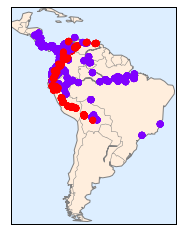

In [23]:
# Basemap으로 해안선 그리기 
m = Basemap(projection = 'cyl', resolution = 'c',
           llcrnrlat = ygrid.min(), urcrnrlat = ygird.max(),
           llcrnrlon = xgrid.min(), urcrnrlon = xgrid.max())

m.drawmapboundary(fill_color = '#DDEEFF')
m.fillcontinents(color = '#FFEEDD')
m.drawcoastlines(color = 'gray', zorder = 2)
m.drawcountries(color = 'gray', zorder = 2)

# 위치 표시하기 
m.scatter(latlon[:,1], latlon[:, 0], zorder =3, 
         c = species, cmap = 'rainbow', latlon = True)

In [26]:
# 등고선 플롯을 위한 데이터 그리드 설정 
X, Y = np.meshgrid(xgrid[::5], ygrid[::5][::-1])
land_reference = data.coverages[6][::5,::5]
land_mask = (land_reference > -9999).ravel()

xy = np.vstack([Y.ravel(), X.ravel()]).T
xy = np.radians(xy[land_mask])

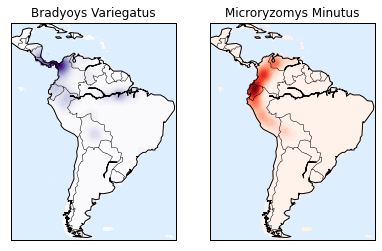

In [30]:
# 두 개의 플롯을 나란히 생성 

fig, ax = plt.subplots(1,2)

fig.subplots_adjust(left = 0.05, right = 0.95, wspace = 0.05)

species_names = ['Bradyoys Variegatus', 'Microryzomys Minutus']
cmaps = ['Purples','Reds']


for i, axi in enumerate(ax):
    axi.set_title(species_names[i])
    
    # Basemap으로 해안선 플로팅 
    m = Basemap(projection ='cyl', llcrnrlat = Y.min(),
               urcrnrlat = Y.max(), llcrnrlon =X.min(),
               urcrnrlon = X.max(), resolution = 'c', ax = axi )
    
    m.drawmapboundary(fill_color ='#DDEEFF')
    m.drawcoastlines()
    m.drawcountries()
    
    # 분포에 대한 구형 커널 밀도추정구성 
    kde = KernelDensity(bandwidth = 0.03, metric = 'haversine')
    kde.fit(np.radians(latlon[species == i]))
    
    # 육지에 대해서만 평가 , -9999: 바다를 나타냄 
    Z = np.full(land_mask.shape[0], -9999.0)
    Z[land_mask] = np.exp(kde.score_samples(xy))
    Z = Z.reshape(X.shape)
    
    # 밀도 등고선 그리기
    levels = np.linspace( 0, Z.max(), 25 )
    axi.contourf(X,Y,Z, levels = levels , cmap = cmaps[i])